In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls '/content/drive'

MyDrive  Shareddrives


In [ ]:
import cv2 as cv  # cv2
import numpy as np #numpy array
import matplotlib.pyplot as plt
import os

In [ ]:
#Give dataset path
Defective_path = '/content/drive/MyDrive/Bottle_cap/Defective'
Non_defective_path = '/content/drive/MyDrive/Bottle_cap/Non-defective (1)'
testing_path ='/content/drive/MyDrive/Bottle_cap/test'

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
            img= cv.resize(img, (500, 500))
            images.append(img)
    return images

In [ ]:
Defective_img = load_images_from_folder(Defective_path)
Non_defective_img = load_images_from_folder(Non_defective_path)
test_img = load_images_from_folder(testing_path)

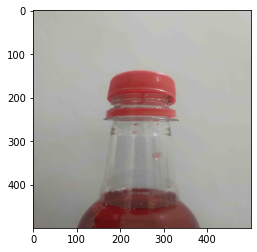

In [ ]:
plt.imshow(Defective_img[0])

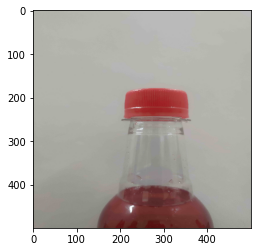

In [ ]:
plt.imshow(Non_defective_img[0])

In [ ]:
pixel_vals = []
pixel_vals1 = []
pixel_vals2=[]

for i in Defective_img:
  tmp = i.reshape((-1,3))
  tmp = np.float32(tmp)
  pixel_vals.append(tmp)

for i in Non_defective_img:
  tmp = i.reshape((-1,3))
  tmp = np.float32(tmp)
  pixel_vals1.append(tmp)

for i in test_img:
  tmp = i.reshape((-1,3))
  tmp = np.float32(tmp)
  pixel_vals2.append(tmp)


In [ ]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.85) 
k = 5

def find_segmented_image(pixel_vals, img_arr):
  segmented_image=[]
  l = len(pixel_vals)
  for i in range(l):
    retval, labels, centers = cv.kmeans(pixel_vals[i], k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers) 
    segmented_data = centers[labels.flatten()]
    segmented_img = segmented_data.reshape((img_arr[i].shape)) 
    segmented_image.append(segmented_img)
  return segmented_image

segmented_image = find_segmented_image(pixel_vals, Defective_img)
segmented_image1 = find_segmented_image(pixel_vals1, Non_defective_img)
segmented_test = find_segmented_image(pixel_vals2, test_img)


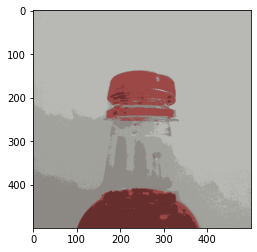

In [ ]:
plt.imshow(segmented_image[0])

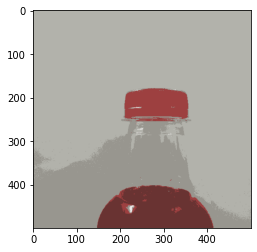

In [ ]:
plt.imshow(segmented_image1[0])

In [ ]:
def ROI_mask(image):
  height = image.shape[0]
  width = image.shape[1]

  
  # A triangular polygon to segment the lane area and discarded other irrelevant parts in the image
  # Defined by three (x, y) coordinates    
  polygons = np.array([ 
        [(100,300 ), (100,100), (400,100), (400,300)] 
      ]) 
  
    
  
  mask = np.zeros_like(image) 
  cv.fillPoly(mask, polygons, color=(255,255,255))  ## 255 is the mask color
  
  # Bitwise AND between canny image and mask image
  masked_image = cv.bitwise_and(image, mask)
  
  return masked_image

In [ ]:
def zoom(img, zoom_factor=2):
    return cv.resize(img, None, fx=zoom_factor, fy=zoom_factor)

def find_mask_img(segmented_img, img):
  l = len(img)
  crop_images = []
  for i in segmented_img:
    crop_img = ROI_mask(i)
    crop_images.append(crop_img)
  
  mask_img = []
  for i in crop_images:
    cropped = i[100:300, 100:400]
    zoomed = zoom(i, 3)
    zoom_crop = zoom(cropped, 3)
    gray = cv.cvtColor(zoom_crop, cv.COLOR_RGB2GRAY)
    mask_img.append(gray)
  return mask_img

mask_img = find_mask_img(segmented_image, Defective_img)
mask_img1 = find_mask_img(segmented_image1, Non_defective_img)
mask_test = find_mask_img(segmented_test,test_img)

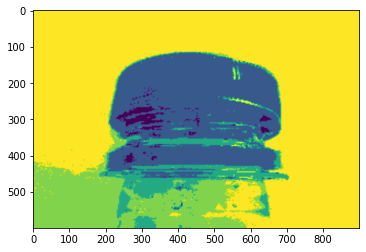

In [ ]:
plt.imshow(mask_img[0])

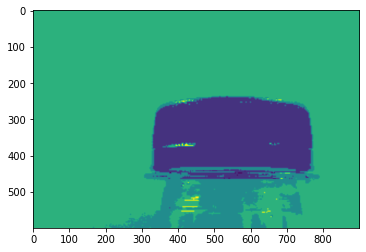

In [ ]:
plt.imshow(mask_img1[0])

In [ ]:
def find_contours(mask_img):
  edges, contours = [], []
  for i in mask_img:
    edge = cv.Canny(i, 30, 200)
    edges.append(edge)
    contour = cv.findContours(edge, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)[0]
    contours.append(contour)
  return edges, contours

edges, contours = find_contours(mask_img)
edges1, contours1 = find_contours(mask_img1)
edges2,contours2 = find_contours(mask_test)

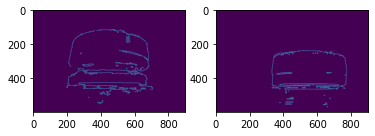

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(edges[0])
plt.subplot(1, 2, 2)
plt.imshow(edges1[0])

In [ ]:
def number_of_contours(contours):
  number_contours = []
  for i in contours:
    number_contours.append(len(i))
  return number_contours

number_contours_defective = number_of_contours(contours)
number_contours_non_defective = number_of_contours(contours1)
predicted = number_of_contours(contours2)
number_contours_defective.sort()
number_contours_non_defective.sort()


In [ ]:
x = np.array(number_contours_defective)
y = np.array(number_contours_non_defective)

x =np.median(x)
y = np.median(y)

Threshold_value = (x+y)/2
Threshold_value

48.75

Non-Defective
Non-Defective
Defective
Defective


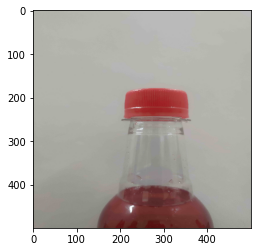

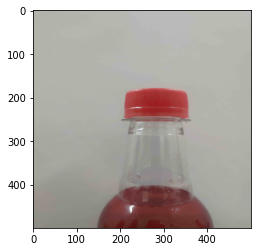

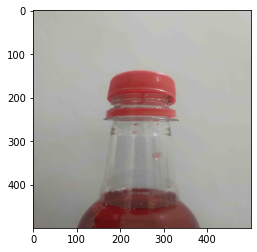

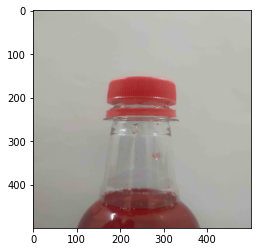

In [ ]:
for i in range(len(predicted)):
  if(predicted[i] > Threshold_value):
    print("Defective" )
  else:
    print("Non-Defective")
  plt.figure()
  plt.imshow(test_img[i])